---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Assignment 4 - Hypothesis Testing
This assignment requires more individual learning than previous assignments - you are encouraged to check out the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/) to find functions or methods you might not have used yet, or ask questions on [Stack Overflow](http://stackoverflow.com/) and tag them as pandas and python related. And of course, the discussion forums are open for interaction with your peers and the course staff.

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

The following data files are available for this assignment:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.

Each function in this assignment below is worth 10%, with the exception of ```run_ttest()```, which is worth 50%.

In [2]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [3]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame should be:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Depending on how you read the data, you may need to remove newline character '\n'. '''
    
    towns_dict = {}
    state_delimiter = '[edit]'
    region_delimiter = '('
    current_state = ''
    with open('../resources/university_towns.txt') as reader:
        for line in reader:
            if state_delimiter in line:
                state = line[:line.index(state_delimiter)]
                current_state = state
                towns_dict[current_state] = []
            else:
                if region_delimiter in line:
                    line = line[:line.index(region_delimiter)]
                
                line = line.strip()
#                 line = line.replace(':', '')
                line = line.replace('\n', '')

                towns_in_state = towns_dict[current_state]
                towns_in_state.append(line)

    data = []
    for state in towns_dict.keys():
        for town in towns_dict[state]:
            data.append((state, town))

    towns = pd.DataFrame(data, columns=['State', 'RegionName'])                        
    return towns

In [4]:
def get_gdp_data():
    gdp_data = pd.read_excel(open('../resources/gdplev.xls', 'rb'),
                       sheet_name='Sheet1', index_col=None, header=None, skiprows=220, nrows=66, usecols=[4, 6])

    gdp_data = gdp_data.rename(columns={4: 'Quarter', 6: 'GDP'})
    #gdp_data = gdp_data.set_index('Quarter')
    return gdp_data

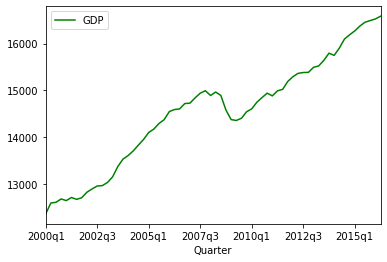

In [10]:
import matplotlib.pyplot as plt

gdp_data = get_gdp_data()
gdp_data.plot(kind='line', x='Quarter', y='GDP', color='green')
plt.show()

In [11]:
def get_recession_start_idx(gdp_values):
    recession_start_idx = -1
    for idx in range(len(gdp_values) - 2):
        if gdp_values[idx] > gdp_values[idx + 1] and gdp_values[idx + 1] > gdp_values[idx + 2]:
            recession_start_idx = idx + 1
            break
    return recession_start_idx

In [12]:
def get_recession_end_idx(gdp_values):
    recession_start_idx = get_recession_start_idx(gdp_values)

    recession_end_idx = -1
    for idx in range(recession_start_idx, len(gdp_values) - 2):
        if gdp_values[idx] < gdp_values[idx + 1] and gdp_values[idx + 1] < gdp_values[idx + 2]:
            recession_end_idx = idx + 2
            break

    return recession_end_idx

In [13]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''

    gdp_data = get_gdp_data()
    gdp_series_arr = gdp_data['GDP'].values

    recession_start_idx = get_recession_start_idx(gdp_series_arr)
    recession_start = gdp_data.iloc[recession_start_idx]
    return recession_start['Quarter']

get_recession_start()

'2008q3'

In [14]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
       
    gdp_data = get_gdp_data()
    gdp_series_arr = gdp_data['GDP'].values

    recession_end_idx = get_recession_end_idx(gdp_series_arr)
    recession_end = gdp_data.iloc[recession_end_idx]
    return recession_end['Quarter']

get_recession_end()

'2009q4'

In [15]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''

    gdp_data = get_gdp_data()
    gdp_series_arr = gdp_data['GDP'].values

    recession_start_idx = get_recession_start_idx(gdp_series_arr)
    recession_end_idx = get_recession_end_idx(gdp_series_arr)

    recession = gdp_data.iloc[recession_start_idx : recession_end_idx + 1]
    bottom_index = recession['GDP'].idxmin()
    recession_bottom = gdp_data.iloc[bottom_index]

    return recession_bottom['Quarter']

get_recession_bottom()

'2009q2'

In [93]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 2000q1 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the assignment description, they are
    not arbitrary three month periods.
    
    The resulting dataframe should have 67 columns, and 10,730 rows.
    '''
    
    index_columns = [1, 2]
    prices_columns = [i for i in range(51, 251)]
    columns_to_select = index_columns + prices_columns
    
    house_prices = pd.read_csv('../resources/City_Zhvi_AllHomes.csv', index_col=None, usecols=columns_to_select)
    for year in range(2000, 2017):
        for month in range(1, 13, 3):
            first_month = '{}-{}'.format(year, str(month).zfill(2))
            second_month = '{}-{}'.format(year, str(month + 1).zfill(2))
            third_month = '{}-{}'.format(year, str(month + 2).zfill(2))

            existing_columns = []
            if first_month in house_prices.columns:
                existing_columns.append(first_month)
            if second_month in house_prices.columns:
                existing_columns.append(second_month)
            if third_month in house_prices.columns:
                existing_columns.append(third_month)

            if len(existing_columns) > 0:
                quarter = '{}q{}'.format(year, int(month / 3) + 1)
                quarter_df = house_prices[existing_columns]
                house_prices[quarter] = quarter_df.mean(axis=1)
                house_prices = house_prices.drop(existing_columns, axis=1)

    house_prices['State'] = house_prices['State'].apply(lambda val : states[val])
    house_prices = house_prices.set_index(['State', 'RegionName'])

    return house_prices

convert_housing_data_to_quarters()

202266.66666666666

In [101]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The variable p should
    be equal to the exact p value returned from scipy.stats.ttest_ind(). The
    value for better should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''
    
    unitowns = get_list_of_university_towns()
    bottom = get_recession_bottom()
    start = get_recession_start()
    hdata = convert_housing_data_to_quarters()
    bstart = hdata.columns[hdata.columns.get_loc(start) - 1]
    hdata['ratio'] = hdata[bottom] - hdata[bstart]
    

    hdata = hdata[[bottom, bstart, 'ratio']]
    hdata = hdata.reset_index()
    
    unitowns_hdata = pd.merge(hdata, unitowns, how='inner', on=['State','RegionName'])
    unitowns_hdata['uni'] = True

    hdata2 = pd.merge(hdata, unitowns_hdata, how='outer', on=['State','RegionName', bottom, bstart, 'ratio'])
    hdata2['uni'] = hdata2['uni'].fillna(False)

    ut = hdata2[hdata2['uni'] == True]
    not_ut = hdata2[hdata2['uni'] == False]

    t,p = ttest_ind(ut['ratio'].dropna(),not_ut['ratio'].dropna())
    
    different = True if p < 0.01 else False

    better = "non-university town" if ut['ratio'].mean() < not_ut['ratio'].mean() else "university town"

    return different, p, better

run_ttest()

(True, 0.002099659657952052, 'university town')